Arvid Lundervold, 2025-01-16

[![Google Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/MMIV-ML/ELMED219-2025/blob/main/Lab2-DL/notebooks/01-MNIST-collect-organize.ipynb)

### NB 1: MNIST Collect and Organize Data


In [1]:
# This is a quick check of whether the notebook is currently running on Google Colaboratory
# as that makes some difference for the code below.
# We'll do this in every notebook of the course.

try:
    import google.colab
    # If this statement executes without error, you're in a Colab environment.
    is_colab = True
    print("Running in Google Colab.")
except ImportError:
    # An ImportError means you're not in a Colab environment.
    is_colab = False
    print("Not running in Google Colab.")

Not running in Google Colab.


In [2]:
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_openml
import matplotlib.pyplot as plt
import os

In [3]:
def load_mnist_tabular(n_samples=None, random_state=42):
    """
    Load MNIST dataset as tabular data using scikit-learn
    
    Parameters:
    -----------
    n_samples : int, optional
        Number of samples to load. If None, loads all 70,000 samples.
        If n_samples is larger than 70,000, uses all available data.
    random_state : int, optional
        Random seed for reproducibility
        
    Returns:
    --------
    X : array-like of shape (n_samples, 784)
        Each row is a flattened 28x28 image
    y : array-like of shape (n_samples,)
        Target labels (digits 0-9)
    """
    print("Loading MNIST data...")
    if is_colab:
        import tensorflow_datasets as tfds

        # Load the full MNIST dataset (70,000 samples)
        dataset = tfds.load('mnist', split='train+test', as_supervised=True)

        # Convert to NumPy arrays
        X, y = [], []
        for image, label in dataset:
            X.append(image.numpy().reshape(784))
            y.append(label.numpy())
        X = np.array(X)
        y = np.array(y)

        # Normalize pixel values
        X = X / 255.0
    else:
        mnist = fetch_openml('mnist_784', version=1, as_frame=True, parser='auto')
        X = mnist.data.values / 255.0  # Scale to [0,1]
        y = mnist.target.astype(int).values  # Convert to numpy array
    
    total_samples = len(X)
    print(f"\nTotal available MNIST samples: {total_samples}")
    
    if n_samples is not None:
        # Make sure we don't try to sample more than available
        n_samples = min(n_samples, total_samples)
        print(f"Using {n_samples} samples")
        
        # Set random seed for reproducibility
        np.random.seed(random_state)
        
        # Take random subset
        indices = np.random.choice(total_samples, n_samples, replace=False)
        X = X[indices]
        y = y[indices]
    
    print("\nMNIST Dataset Info:")
    print(f"Features (pixels): {X.shape[1]}")
    print(f"Classes: {len(np.unique(y))}")
    print(f"\nClass distribution:")
    print(pd.Series(y).value_counts().sort_index())
    
    return X, y

Loading MNIST data...

Total available MNIST samples: 70000
Using 5000 samples

MNIST Dataset Info:
Features (pixels): 784
Classes: 10

Class distribution:
0    490
1    551
2    483
3    556
4    433
5    476
6    490
7    515
8    489
9    517
Name: count, dtype: int64

Feature Statistics:
       pixel_0  pixel_1  pixel_2  pixel_3  pixel_4  pixel_5  pixel_6  pixel_7  \
count   5000.0   5000.0   5000.0   5000.0   5000.0   5000.0   5000.0   5000.0   
mean       0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
std        0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
min        0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
25%        0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
50%        0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
75%        0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
max        0.0      0.0      0.0      0.0      0.0      0.0

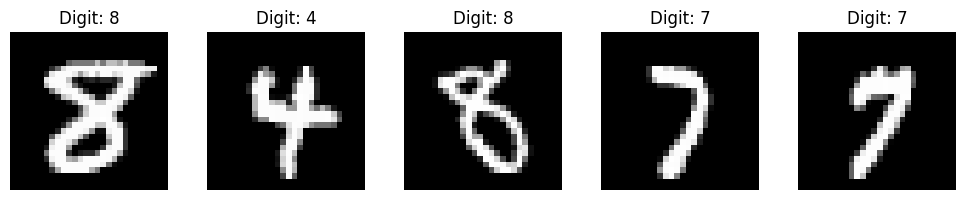


Feature Analysis:
Zero-variance features: 118
Features with >50% zeros: 15

Top 10 most correlated pixels with digit label:
pixel_381    0.427864
pixel_436    0.416663
pixel_408    0.411302
pixel_409    0.408674
pixel_464    0.367394
pixel_354    0.358443
pixel_353    0.355289
pixel_437    0.353728
pixel_382    0.338701
pixel_380    0.314135
Name: label, dtype: float64
Number of NaN values: 117


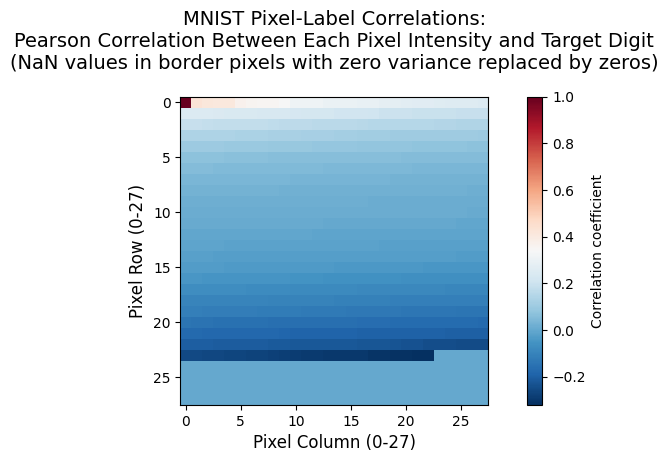

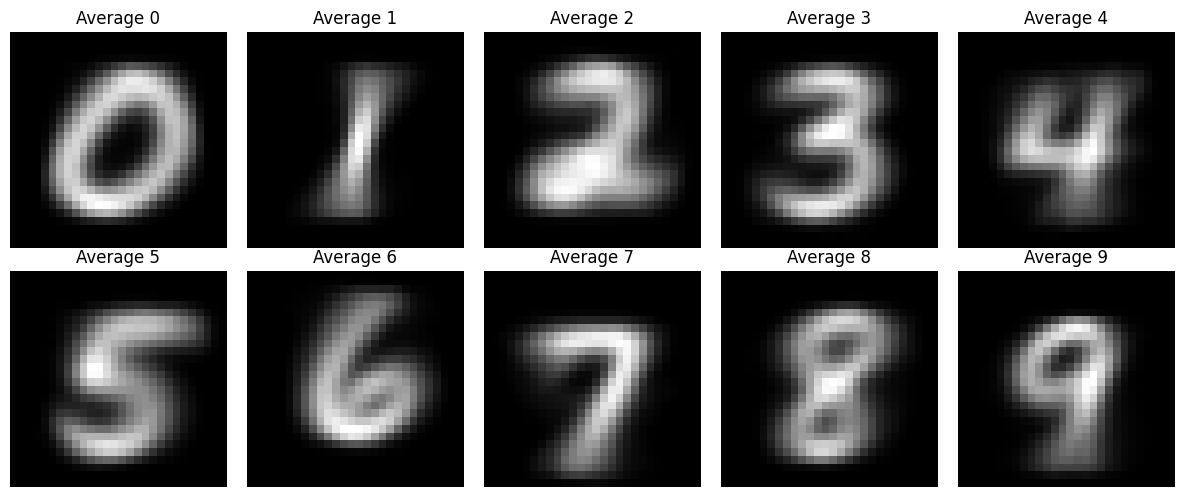

In [4]:
# Load a subset of the data
n_desired_samples = 5000  # Adjust this up to 70,000 as needed
X, y = load_mnist_tabular(n_samples=n_desired_samples)

# Convert to DataFrame for exploration
feature_names = [f'pixel_{i}' for i in range(784)]
df = pd.DataFrame(X, columns=feature_names)
df['label'] = y

# Basic statistics
print("\nFeature Statistics:")
print(df.describe().round(3))

# Visualize examples
def plot_examples(X, y, n_examples=5):
    """Plot example digits"""
    fig, axes = plt.subplots(1, n_examples, figsize=(2*n_examples, 2))
    
    for i in range(n_examples):
        # Reshape to 28x28
        img = X[i].reshape(28, 28)
        
        # Plot
        axes[i].imshow(img, cmap='gray')
        axes[i].axis('off')
        axes[i].set_title(f'Digit: {y[i]}')
    
    plt.tight_layout()
    plt.show()

# Plot first 5 examples
plot_examples(X, y)

# Feature analysis
print("\nFeature Analysis:")
print("Zero-variance features:", (df.var() == 0).sum())
print("Features with >50% zeros:", (df == 0).mean()[df.mean() > 0.5].count())

# Correlation with target
correlations = df.corr()['label'].sort_values(ascending=False)
print("\nTop 10 most correlated pixels with digit label:")
print(correlations[1:11])  # Skip 'label' itself

# Visualize feature correlations
# First, check for any NaN values
print("Number of NaN values:", np.isnan(correlations[:-1]).sum())

# Replace NaN values with 0 (or you could use the mean correlation value)
correlation_clean = np.nan_to_num(correlations[:-1].values, nan=0)

# Visualize feature correlations with NaN values handled
plt.figure(figsize=(10, 4))
plt.title("MNIST Pixel-Label Correlations:\n"
          "Pearson Correlation Between Each Pixel Intensity and Target Digit\n"
          "(NaN values in border pixels with zero variance replaced by zeros)", 
          fontsize=14, pad=20)
correlation_map = correlation_clean.reshape(28, 28)
plt.imshow(correlation_map, cmap='RdBu_r')
plt.colorbar(label='Correlation coefficient')
plt.xlabel('Pixel Column (0-27)', fontsize=12)
plt.ylabel('Pixel Row (0-27)', fontsize=12)
plt.show()


# Optional: Show average digit images per class
def plot_average_digits(X, y):
    """Plot average image for each digit"""
    fig, axes = plt.subplots(2, 5, figsize=(12, 5))
    axes = axes.ravel()
    
    for digit in range(10):
        digit_imgs = X[y == digit]
        avg_digit = digit_imgs.mean(axis=0).reshape(28, 28)
        
        axes[digit].imshow(avg_digit, cmap='gray')
        axes[digit].axis('off')
        axes[digit].set_title(f'Average {digit}')
    
    plt.tight_layout()
    plt.show()

plot_average_digits(X, y)

In [6]:
df.shape

(5000, 785)

In [7]:
df.describe()

pixel_0  pixel_1  pixel_2  pixel_3  pixel_4  pixel_5  pixel_6  pixel_7  \
count   5000.0   5000.0   5000.0   5000.0   5000.0   5000.0   5000.0   5000.0   
mean       0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
std        0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
min        0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
25%        0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
50%        0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
75%        0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
max        0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   

       pixel_8  pixel_9  ...    pixel_775    pixel_776    pixel_777  \
count   5000.0   5000.0  ...  5000.000000  5000.000000  5000.000000   
mean       0.0      0.0  ...     0.000292     0.000275     0.000114   
std        0.0      0.0  ...     0.014827     0.013817     0.007161   
min        0.0      0.0  ...     0.000000     0.000000     0.000000   
25%        0.0      0.0  ...     0.000000     0.000000     0.000000   
50%        0.0      0.0  ...     0.000000     0.000000     0.000000   
75%        0.0      0.0  ...     0.000000     0.000000     0.000000   
max        0.0      0.0  ...     0.996078     0.749020     0.501961   

       pixel_778  pixel_779  pixel_780  pixel_781  pixel_782  pixel_783  \
count     5000.0     5000.0     5000.0     5000.0     5000.0     5000.0   
mean         0.0        0.0        0.0        0.0        0.0        0.0   
std          0.0        0.0        0.0        0.0        0.0        0.0   
min          0.0        0.0        0.0        0.0        0.0        0.0   
25%          0.0        0.0        0.0        0.0        0.0        0.0   
50%          0.0        0.0        0.0        0.0        0.0        0.0   
75%          0.0        0.0        0.0        0.0        0.0        0.0   
max          0.0        0.0        0.0        0.0        0.0        0.0   

            label  
count  5000.00000  
mean      4.48140  
std       2.89678  
min       0.00000  
25%       2.00000  
50%       4.00000  
75%       7.00000  
max       9.00000  

[8 rows x 785 columns]

In [8]:
# Save the data to a CSV file  to mnist_images subdirectory

# Make a subdirectory for the images
os.makedirs('mnist_images', exist_ok=True)

df.to_csv(f'mnist_images/mnist_data_{n_desired_samples}x{df.shape[1]}.csv', index=False)
print(f"Data saved to 'mnist_images/mnist_data_{n_desired_samples}x{df.shape[1]}.csv'")

Data saved to 'mnist_images/mnist_data_5000x785.csv'


In [9]:
def save_mnist_data(X, y, output_dir='mnist_images'):
    """
    Save MNIST images and create a CSV file with filenames and labels
    
    Parameters:
    -----------
    X : array-like of shape (n_samples, 784)
        The image data
    y : array-like of shape (n_samples,)
        The labels
    output_dir : str
        Directory to save images and CSV
    """
    # Create directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    # Create list to store file information
    file_info = []
    
    # Save images and collect file info
    for i in range(len(X)):
        # Create filename with leading zeros
        filename = f'mnist_image_{i:04d}.png'
        filepath = os.path.join(output_dir, filename)
        
        # Save image
        img = X[i].reshape(28, 28)
        plt.imsave(filepath, img, cmap='gray')
        
        # Collect file info
        file_info.append({
            'file_name': filename,
            'label': int(y[i])
        })
    
    # Create and save DataFrame
    df_files = pd.DataFrame(file_info)
    csv_path = os.path.join(output_dir, 'mnist_labels.csv')
    df_files.to_csv(csv_path, index=False)
    
    print(f"Saved {len(X)} images to {output_dir}/")
    print(f"Saved labels to {csv_path}")
    print("\nFirst few rows of the CSV file:")
    print(df_files.head())
    
    return df_files

# After loading the MNIST data, save images and create CSV
df_mnist = save_mnist_data(X, y)

Saved 5000 images to mnist_images/
Saved labels to mnist_images/mnist_labels.csv

First few rows of the CSV file:
              file_name  label
0  mnist_image_0000.png      8
1  mnist_image_0001.png      4
2  mnist_image_0002.png      8
3  mnist_image_0003.png      7
4  mnist_image_0004.png      7
